<h1><span style="color:green">The GREEN exercise</span></h1>

Patterns from each of ***two classes have been drawn from distributions with the same mean***. I.e. on average the patterns associated with each class are identical, and typically we would not want to conclude that the classes differ. However, a simple classification has been run for each of 40 participants, and the ***classifier accuracy is significantly above chance***. 

***Is this correct? Change the analysis so that it no longer finds a significant difference between the classes.***

## Getting ready

Import the packages we might need:

In [1]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import scipy                    # This provides scientific capabilities like t-tests

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut...
from sklearn import linear_model # includes LogisticRegression, RidgeClassifier...
from sklearn import svm # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics # includes roc_auc_score...
from sklearn import pipeline # includes make_pipeline

Set the random number generator:

In [2]:
np.random.seed(1)

## Simulate some data (two, balanced classes) with no mean difference between conditions:

In [3]:
npeople = 40 # number of participants

nvox = 2 # number of voxels
nruns= 6 # number of runs
n_samples_per_run = 10 # number of samples/patterns per run; these will be divided into conditions/classes "0" and "1"
proportion_of_samples_from_condition_0 = 0.5

mu = np.arange(nvox)+1 # mean activation for both conditions (voxels all have different activation strength)
voxel_covariance = np.diag(mu)+1 # voxel covariance: independent noise per voxel plus some covariance

null_data = [] # list of pattern matrices (one per participant)

for p in np.arange(npeople):
    
    null_data_per_run = [] # list of pattern matrices (one for each run)
    labels_per_run = []    # list of label vectors (one for each run)
    for r in np.arange(nruns):
        # label each sample as condition 0 or 1 (the +0 is a trick to convert the logical values to integers):
        label_vector= ((np.arange(n_samples_per_run)/n_samples_per_run)>=proportion_of_samples_from_condition_0)+0;
        
        # sample activations with patterns from each class having the same mean:
        data_matrix0 =  np.random.multivariate_normal(mu, voxel_covariance, size=np.sum(label_vector==0))
        data_matrix1 =  np.random.multivariate_normal(mu, voxel_covariance*8, size=np.sum(label_vector==1))
        data_matrix  =  np.concatenate((data_matrix0, data_matrix1))
        
        null_data_per_run.append( data_matrix ) 
        labels_per_run.append( label_vector ) 
    
    # concatenate runs for this participant
    null_data.append(   np.concatenate(null_data_per_run, axis=0) )

# same for all particiapnts:
labels =      np.concatenate(labels_per_run, axis=0) 
run_indices = np.concatenate([[i] * n_samples_per_run for i in range(nruns)]) 

\
Plot the data for the first two voxels of the first participant:

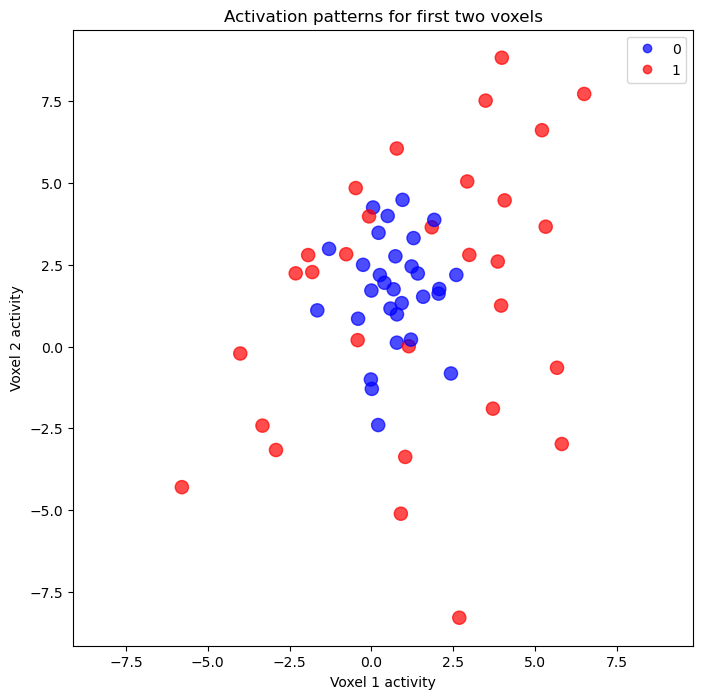

In [4]:
plt.figure(figsize=(8,8))  # create a matplotlib figure
plt.title('Activation patterns for first two voxels')
scatter = plt.scatter(null_data[0][:,[0]], null_data[0][:,[1]], 
                      s= 90, alpha=0.7, c=labels, cmap='bwr')
plt.legend(handles=scatter.legend_elements()[0], labels=set(np.unique(labels))) # "set" returns unique values
plt.xlabel('Voxel 1 activity')
plt.ylabel('Voxel 2 activity')
plt.rcParams.update({'font.size': 18})
plt.axis('equal')
plt.show()

\
Specify the pre-processing, classification pipeline, and leave-one-run-out cross-validation scheme:

In [5]:
scaler = skl.preprocessing.StandardScaler()
SVM    = skl.svm.SVC()
pipe   = skl.pipeline.make_pipeline(scaler, SVM)
logo   = skl.model_selection.LeaveOneGroupOut()  

\
Run the classification for each participant:

In [6]:
accuracy = np.full(npeople, np.nan)
for p in np.arange(npeople):
    accuracy_per_fold = skl.model_selection.cross_val_score(pipe, null_data[p], labels, groups  = run_indices, cv = logo, scoring = 'balanced_accuracy')
    accuracy[p] = np.mean(accuracy_per_fold)
    print("Participant ", p, ": Accuracy per fold: ", accuracy_per_fold, "Mean accuracy (for random data):", accuracy[p])

Participant  0 : Accuracy per fold:  [0.7 1.  0.7 0.9 0.7 0.9] Mean accuracy (for random data): 0.8166666666666668
Participant  1 : Accuracy per fold:  [0.9 0.8 0.7 0.9 0.9 0.7] Mean accuracy (for random data): 0.8166666666666668
Participant  2 : Accuracy per fold:  [0.7 1.  0.7 0.8 1.  0.8] Mean accuracy (for random data): 0.8333333333333334
Participant  3 : Accuracy per fold:  [0.8 0.9 0.9 0.8 0.9 0.8] Mean accuracy (for random data): 0.8500000000000001
Participant  4 : Accuracy per fold:  [0.8 0.8 0.7 0.8 0.7 0.8] Mean accuracy (for random data): 0.7666666666666666
Participant  5 : Accuracy per fold:  [0.8 0.7 0.7 0.8 0.7 0.7] Mean accuracy (for random data): 0.7333333333333334
Participant  6 : Accuracy per fold:  [0.9 0.8 0.8 0.9 0.8 0.5] Mean accuracy (for random data): 0.7833333333333333
Participant  7 : Accuracy per fold:  [0.7 0.8 0.8 0.8 1.  0.9] Mean accuracy (for random data): 0.8333333333333334
Participant  8 : Accuracy per fold:  [0.8 0.7 1.  0.8 0.7 1. ] Mean accuracy (fo

\
Run a one-sample t-test across participants and find a significant difference between classes:

In [7]:
result = scipy.stats.ttest_1samp(accuracy, 0.5, alternative='greater')
print("Mean accuracy across participants (for random data):", np.mean(accuracy))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

Mean accuracy across participants (for random data): 0.80625
t(39) = 35.87; p = 8.86e-32


## Questions:
 - We have two classes, drawn from distributions with the same mean pattern, so why is accuracy not close to 0.5?
 - Is the classifier performing as it should?
 - Can you change the analysis to get a classification score closer to a level equivalent to 50% accuracy?

## Hints:
- Consider the data that is being provided to the classifier per class.
- What classifier is being used? Consider other options when creating it.
- Is there a "better" way to measure classifier performance?

## Explanation and possible solutions:

The two classes come from distributions with the same mean, but different variances. Classifiers can typically use information in the variance to distinguish the classes. Sometimes, two representations might meaningfully differ in their variance, and the brain might be able to use this information, and we might be interested in capturing it. However, classes can also have different variance for uninteresting reasons: one condition might be based on fewer trials; particpants might move more in one condition; participants might pay more attention in one condition, etc.

The classifier is doing exactly what it is supposed to: maximizing its average classification performance. The issue is that the classifier can use information in the pattern variance, whereas we might only be interested in the mean pattern.

The classifier used in the example is a support vector machine (SVM) initialised with no input arguments. This defaults to a non-linear (radial basis function) classifier, which is very sensitive to class variance. 

A simpler, linear classifier is less prone to overfitting (which is typically better for fMRI data anyway), and is also less sensitive to differences in pattern variance. A linear SVM can be specified like this:


In [8]:
SVM    = skl.svm.SVC(kernel = 'linear') ##################### The change
pipe   = skl.pipeline.make_pipeline(scaler, SVM)

for p in np.arange(npeople):
    accuracy_per_fold = skl.model_selection.cross_val_score(pipe, null_data[p], labels, groups  = run_indices, cv = logo, scoring = 'balanced_accuracy')
    accuracy[p] = np.mean(accuracy_per_fold)
    
result = scipy.stats.ttest_1samp(accuracy, 0.5, alternative='greater')
print("Mean accuracy across participants (for random data):", np.mean(accuracy))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

Mean accuracy across participants (for random data): 0.6016666666666667
t(39) = 10.82; p = 1.30e-13


Accuracy is closer to chance, but still significantly above chance.

\
There is another way to specify a linear SVM:

In [9]:
SVM    = skl.svm.LinearSVC(dual='auto') ##################### The change
pipe   = skl.pipeline.make_pipeline(scaler, SVM)

for p in np.arange(npeople):
    accuracy_per_fold = skl.model_selection.cross_val_score(pipe, null_data[p], labels, groups  = run_indices, cv = logo, scoring = 'balanced_accuracy')
    accuracy[p] = np.mean(accuracy_per_fold)
    
result = scipy.stats.ttest_1samp(accuracy, 0.5, alternative='greater')
print("Mean accuracy across participants (for random data):", np.mean(accuracy))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

Mean accuracy across participants (for random data): 0.5266666666666667
t(39) = 1.84; p = 3.68e-02


This time the accuracy is much closer to chance, but still signficantly above chance. I'm not sure of the exact difference between these two implementations of a linear SVM, or why they seem to have different sensitivity to pattern variance. If you know, please tell me!

\
Anyway, the accuracy of a linear classifier is less sensitive to differences in pattern variance than the accuracy of a non-linear classifier, but still has some sensitivity to pattern variance. (Imagine placing the classification boundary just to one side of the inner cluster: predictions for the inner cluster will always be correct, and predictions for the noiser cluster will only sometimes be wrong.)


\
For linear classifiers, a performance metric that should, on average, be insensitive to pattern variance is the mean signed distance to the decision boundary, where the sign is positive for correct classifications and negative for misclassifications. This metric should have an expectation of zero, under the null hypothesis of no mean difference in patterns, regardless of pattern variance:

Mean signed distance to hyperplane across participants (for random data): -0.0069533202708680795
t(39) = -1.30; p = 8.99e-01


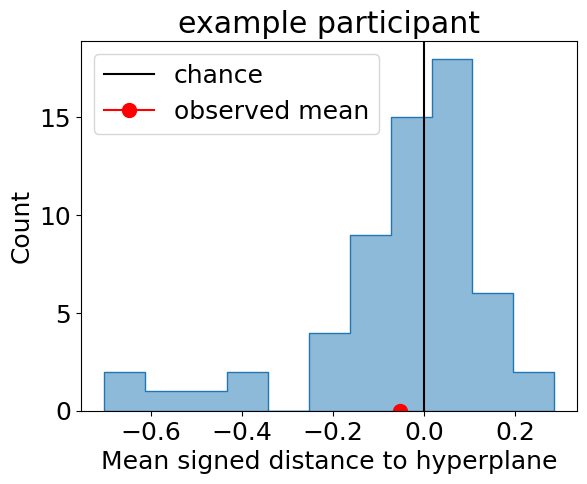

In [10]:
signed_decisions = np.full(npeople, np.nan)
for p in np.arange(npeople):
    decisions = skl.model_selection.cross_val_predict(pipe, null_data[p], labels, groups  = run_indices, cv = logo, method = 'decision_function')
    # For a linear classifier, these are distances of each test sample to the hyperplane, with the sign indicating the predicted class.
    # To get a measure of performance, we want the sign to indicate accuracy:
    predictions = skl.model_selection.cross_val_predict(pipe, null_data[p], labels, groups  = run_indices, cv = logo, method = 'predict') # binary class assignments
    accuracy = (predictions==labels)*2-1   # +1 for correct, -1 for incorrect
    signed_decisions_per_sample = np.abs(decisions) * accuracy
    signed_decisions[p] = np.mean(signed_decisions_per_sample)

result = scipy.stats.ttest_1samp(signed_decisions, 0, alternative='greater')
print("Mean signed distance to hyperplane across participants (for random data):", np.mean(signed_decisions))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

ax = sns.histplot(signed_decisions_per_sample, element='step', alpha=0.5)
ax.set(xlabel = 'Mean signed distance to hyperplane');
ax.set(title = 'example participant');
lh = ax.axvline(0, color='k',label='chance')
mh = ax.plot(np.mean(signed_decisions_per_sample), 0, marker='o', color='r', markersize=10, label='observed mean')
ax.legend();